#Import Necessary Libraries

In [ ]:
!pip -q install yellowbrick==1.3
!pip -q install kneed
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install plotly
!pip install squarify
!pip install chart_studio
!pip -q install factor_analyzer
! pip install distance
!pip install sentence-transformers

     |████████████████████████████████| 271 kB 5.2 MB/s 
     |████████████████████████████████| 50 kB 3.1 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149868 sha256=3a01dbae262fefe1435e056b4623d309b1d3f217fbeb14854af5e85e011b9d4e
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
     |████████████████████████████████| 64 kB 2.0 MB/s 
     |████████████████████████████████| 41 kB 296 kB/s 
     |████████████████████████████████| 180 kB 5.2 MB/s 
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=13deed2b8989b22a7082ce6d85b5b0756ea9c5bb1656f10c95bb81d4ae1665ac
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance
     |████████████████████████████████| 78 kB 3.7 MB/s 
     |████████████████████████████████| 3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly
import plotly.express as px
import plotly.io as pio
import datetime
import squarify

import warnings
warnings.filterwarnings('ignore')

# Pre-processing data
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import functools
from functools import lru_cache
from bs4 import BeautifulSoup
import re

# Word embedding model Word2Vec
import gensim
import gensim.downloader as gensim_api
from gensim.models.word2vec import Word2Vec
from sklearn.decomposition import PCA

# Bag of words TD-IDF
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

# Advanced feature extraction
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# import data
from google.colab import files
import openpyxl

pio.renderers.default = 'colab' 
import distance

from sentence_transformers import SentenceTransformer, util
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Building Models

In [ ]:
# Building models 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

## Random Forest

### Prepare Data

In [ ]:
from numpy import arange, mean, std
from matplotlib import pyplot

path = "/content/drive/MyDrive/CS3244/stopwords_lemmatize_features.csv"
train_stopwords_lemmatize=pd.read_csv(path).head(100000)
path = "/content/drive/MyDrive/CS3244/stopwords_features.csv"
train_stopwords_features=pd.read_csv(path).head(100000)
path = "/content/drive/MyDrive/CS3244/cleaned_features.csv"
train_cleaned_features=pd.read_csv(path).head(100000)

path = "/content/drive/MyDrive/CS3244/cleaned_vectors.csv"
train_cleaned_vectors=pd.read_csv(path).head(100000)

raw_data = [train_stopwords_lemmatize,train_stopwords_features,train_cleaned_features]

# pd.set_option('display.max_colwidth', None)

In [ ]:
train_cleaned_features.head()

,is_duplicate,qid1,qid2,question1_cleaned,question2_cleaned,cosine_similarity,q1_word_count,q2_word_count,q1char_count,q2char_count,freq_qid1,freq_qid2,common_words_count,total_unique_num_words,tot_words,words_ratio,Simple_Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio
0,0,1,2,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market,0.891528,14,12,65,56,1,1,11,12,23,0.478261,93,100,93,100
1,0,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government stole the kohinoor koh i noor diamond back,0.667396,10,15,48,85,4,1,7,17,24,0.291667,65,73,63,86
2,0,5,6,how can i increase the speed of my internet connection while using a vpn,how can internet speed be increased by hacking through dns,0.499441,14,10,72,58,1,1,4,20,24,0.166667,54,53,66,66
3,0,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is divided by 24 23,0.165055,11,13,48,59,1,1,0,20,20,0.000000,36,40,36,36
4,0,9,10,which one dissolve in water quikly sugar salt methane and carbon di oxide,which fish would survive in salt water,0.211917,13,7,73,38,3,1,4,16,20,0.200000,45,55,47,67


In [ ]:
train_stopwords_features.head()

,is_duplicate,qid1,qid2,question1_stopwords,question2_stopwords,cosine_similarity,q1_word_count,q2_word_count,q1char_count,q2char_count,freq_qid1,freq_qid2,total_unique_num_words,common_words_count,tot_words,words_ratio,Simple_Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio
0,0,1,2,step step guide invest share market india,step step guide invest share market,0.915769,7,6,41,35,1,1,6,5,11,0.454545,92,100,92,100
1,0,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor koh noor diamond back,0.631077,5,10,31,67,4,1,11,4,15,0.266667,59,94,59,89
2,0,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0.422253,6,5,44,36,1,1,9,2,11,0.181818,55,56,70,70
3,0,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0.236682,3,9,21,44,1,1,9,0,9,0.000000,22,24,22,22
4,0,9,10,one dissolve water quikly sugar salt methane carbon di oxide,fish would survive salt water,0.225030,10,5,60,29,3,1,13,2,15,0.133333,43,52,40,51


In [ ]:
train_stopwords_lemmatize.head()

,is_duplicate,qid1,qid2,question1_stopwords_lemmatize,question2_stopwords_lemmatize,cosine_similarity,q1_word_count,q2_word_count,q1char_count,q2char_count,freq_qid1,freq_qid2,total_unique_num_words,common_words_count,tot_words,words_ratio,Simple_Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio
0,0,1,2,step step guide invest share market india,step step guide invest share market,0.915769,7,6,41,35,1,1,6,5,11,0.454545,92,100,92,100
1,0,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor koh noor diamond back,0.631077,5,10,31,67,4,1,11,4,15,0.266667,59,94,59,89
2,0,5,6,increase speed internet connection use vpn,internet speed increase hack dns,0.517595,6,5,42,32,1,1,8,3,11,0.272727,51,56,70,84
3,0,7,8,mentally lonely solve,find remainder math 23 24 math divide 24 23,0.241359,3,9,21,43,1,1,9,0,9,0.000000,22,24,22,23
4,0,9,10,one dissolve water quikly sugar salt methane carbon di oxide,fish would survive salt water,0.225030,10,5,60,29,3,1,13,2,15,0.133333,43,52,40,51


In [ ]:
def split(arrStr):
	arrStr = arrStr[1:len(arrStr)-1]
	arrStr = arrStr.split()
	return arrStr
def manhattan_dist(d1, d2):
	return [manhattan_distances([d1[i]], [d2[i]])[0] for i in range(d1.shape[0])]

def cos_similarity(d1, d2):
	return [cosine_similarity([d1[i]], [d2[i]])[0] for i in range(d1.shape[0])]

vectors_1 = train_cleaned_vectors['q1_word_vector'].apply(lambda x: np.asarray(split(x), dtype=np.float64))
vectors_2 = train_cleaned_vectors['q2_word_vector'].apply(lambda x: np.asarray(split(x), dtype=np.float64))

vectors_cos_similarity = cos_similarity(vectors_1, vectors_2)
vectors_manhattan = manhattan_dist(vectors_1, vectors_2)

data = []
for orig_data in raw_data:
  new_data = orig_data.head(100000)
  new_data['vectors_cos_similarity'] = vectors_cos_similarity
  new_data['vectors_manhattan'] = vectors_manhattan
  data.append(new_data)


In [ ]:
def get_train_data(train_clean):
  y = train_clean["is_duplicate"]
  X = train_clean.drop(['q1_word_vector' ,'q2_word_vector','is_duplicate', 'qid1', 'qid2', 'freq_qid1', 'freq_qid2','Unnamed: 0', 'question1_stopwords_lemmatize','question2_stopwords_lemmatize', 'question1_stopwords', 'question2_stopwords', 'question1_cleaned', 'question2_cleaned', 'Token_Sort_Ratio', 'q1char_count','q2char_count','tot_words'], axis = 1, errors='ignore')
  return (X, y)

### Hyperparameter tuning

In [ ]:
from scipy.stats import loguniform

def randomized_search(model, X, y):
  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 1050, stop = 1100, num = 10)]
  # Number of features to consider at every split
  max_features = ['auto', 'sqrt']
  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(5, 10, num = 1)]
  max_depth.append(None)
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [1, 2, 4]
  # Method of selecting samples for training each tree
  bootstrap = [True, False]

  # Create the random grid
  random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
  search = RandomizedSearchCV(model, random_grid, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

  result = search.fit(X, y)
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)

def grid_search(model, X, y, param_grid):
  grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring="accuracy")

  # Fit grid search to data
  grid_search.fit(X, y)
  print(grid_search.best_params_)

In [ ]:
rf = RandomForestClassifier()
for train_data in raw_data:
  X, y = get_train_data(train_data)
  randomized_search(rf, X, y)

# Best Score: 0.8420300000000001
# Best Hyperparameters: {'n_estimators': 1072, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}

Best Score: 0.8420300000000001
Best Hyperparameters: {'n_estimators': 1072, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


KeyboardInterrupt: ignored

In [ ]:
# based on results of RandomizedSearchCV
param_grid = {'n_estimators': [1062, 1072], 'min_samples_split': [1, 2], 'min_samples_leaf': [1, 2], 'max_features': ['auto'], 'bootstrap': [True]}

In [ ]:
for train_data in raw_data:
  X, y = get_train_data(train_data)
  grid_search(rf, X, y, param_grid)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 19.9min finished


{'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1062}
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
# params from GridSearchCV
params = {'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1062}
rf = RandomForestClassifier(**params)

### Feature Importance

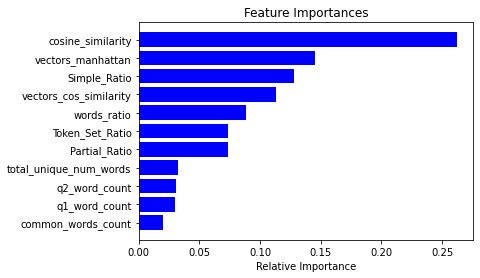

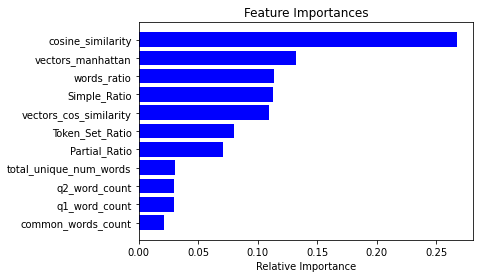

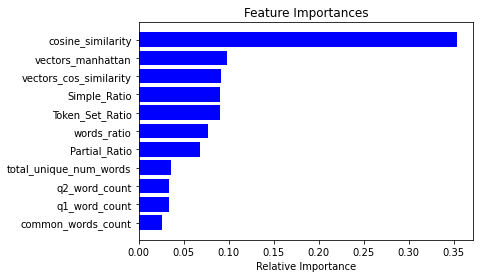

In [ ]:
for train_clean in data:
  X, y = get_train_data(train_clean)
  # Split data into training and validation data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)
  features = X.columns.values

  rf.fit(X_train, y_train)

  importances = rf.feature_importances_
  indices = np.argsort(importances)

  plt.title('Feature Importances')
  plt.barh(range(len(indices)), importances[indices], color='b', align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.show()

### Evaluate Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
for train_clean in data:
  X, y = get_train_data(train_clean)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)
  features = X.columns.values

  rf.fit(X_train, y_train)
  # make predictions for test data
  y_pred = rf.predict(X_test)
  # evaluate predictions
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  y_pred2 = rf.predict_proba(X_test)
  ll = log_loss(y_test, y_pred2)
  print("------------------------")
  print('Accuracy: %f' % accuracy)
  print('Precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 Score: %f' % f1)
  print('AUC-ROC: %f' % roc_auc)
  print('Log Loss: %f' % ll)
  print("------------------------")

------------------------
Accuracy: 0.778520
Precision: 0.686196
Recall: 0.728821
F1 Score: 0.706866
AUC-ROC: 0.768041
Log Loss: 0.432070
------------------------
------------------------
Accuracy: 0.789520
Precision: 0.694939
Recall: 0.758515
F1 Score: 0.725337
AUC-ROC: 0.782982
Log Loss: 0.416069
------------------------
------------------------
Accuracy: 0.824000
Precision: 0.740210
Recall: 0.800655
F1 Score: 0.769247
AUC-ROC: 0.819078
Log Loss: 0.370518
------------------------


### Result Visualization

In [ ]:
def compute_roc_auc(model_, index):
 y_predict = model_.predict_proba(X.iloc[index])[:,1]
 fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict)
 auc_score = metrics.auc(fpr, tpr)
 return fpr, tpr, auc_score

In [ ]:
def plot_roc_curve(fprs, tprs):
 # Initialize useful lists + the plot axes.
 tprs_interp = []
 aucs = []
 mean_fpr = np.linspace(0, 1, 100)
 f, ax = plt.subplots(figsize=(18,10))
 
 # Plot ROC for each K-Fold + compute AUC scores.
 for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
   tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
   tprs_interp[-1][0] = 0.0
   roc_auc = metrics.auc(fpr, tpr)
   aucs.append(roc_auc)
   ax.plot(fpr, tpr, lw=2, alpha=0.3, label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))
 
 # Plot the luck line
 plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
 label="Random", alpha=.8)
 
 # Plot the mean ROC.
 mean_tpr = np.mean(tprs_interp, axis=0)
 mean_tpr[-1] = 1.0
 mean_auc = metrics.auc(mean_fpr, mean_tpr)
 std_auc = np.std(aucs)
 ax.plot(mean_fpr, mean_tpr, color='b',
 label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
 lw=4, alpha=.8)
 
 # Plot the standard deviation around the mean ROC.
 std_tpr = np.std(tprs_interp, axis=0)
 tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
 tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
 ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
 label=r"$\pm$ 1 std. dev.")
 
 # Fine tune and show the plot.
 ax.set_xlim([-0.05, 1.05])
 ax.set_ylim([-0.05, 1.05])
 ax.set_xlabel("False Positive Rate (FPR)")
 ax.set_ylabel("True Positive Rate (TPR)")
 ax.set_title("ROC-AUC")
 ax.legend(loc="lower right")
 plt.show()
 return (f, ax)

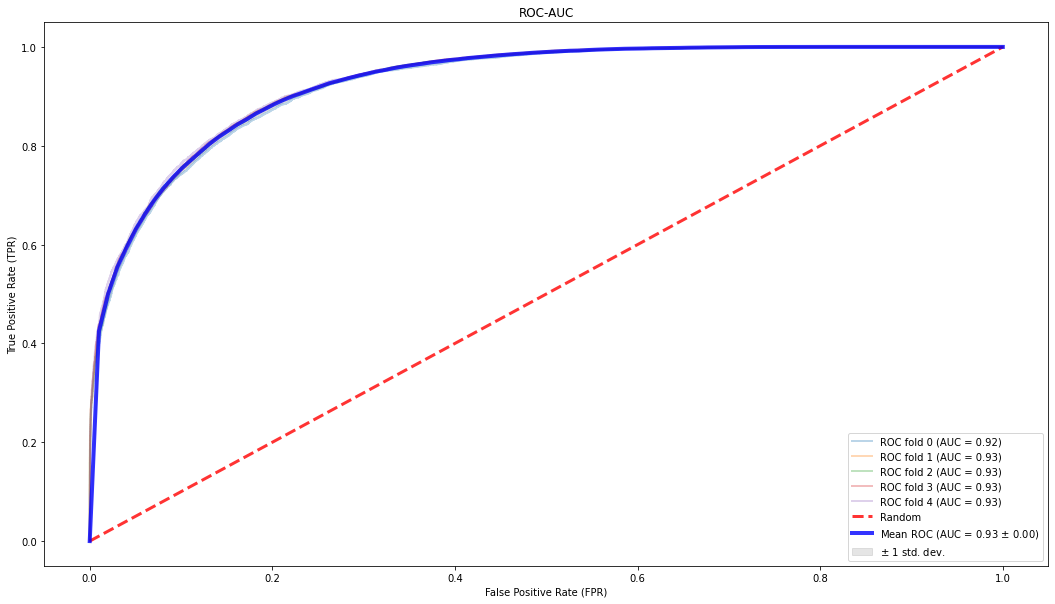

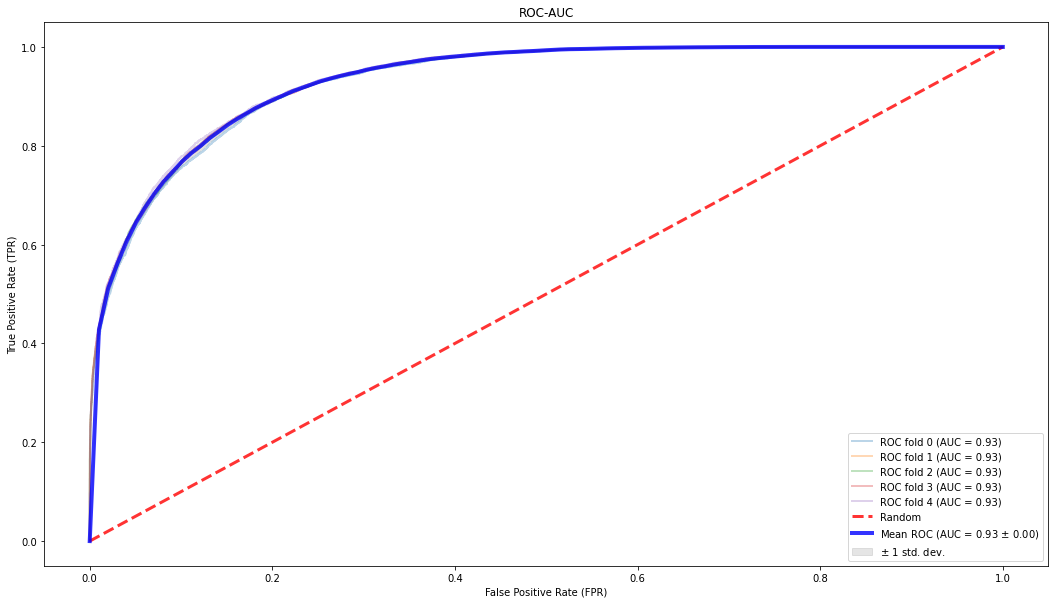

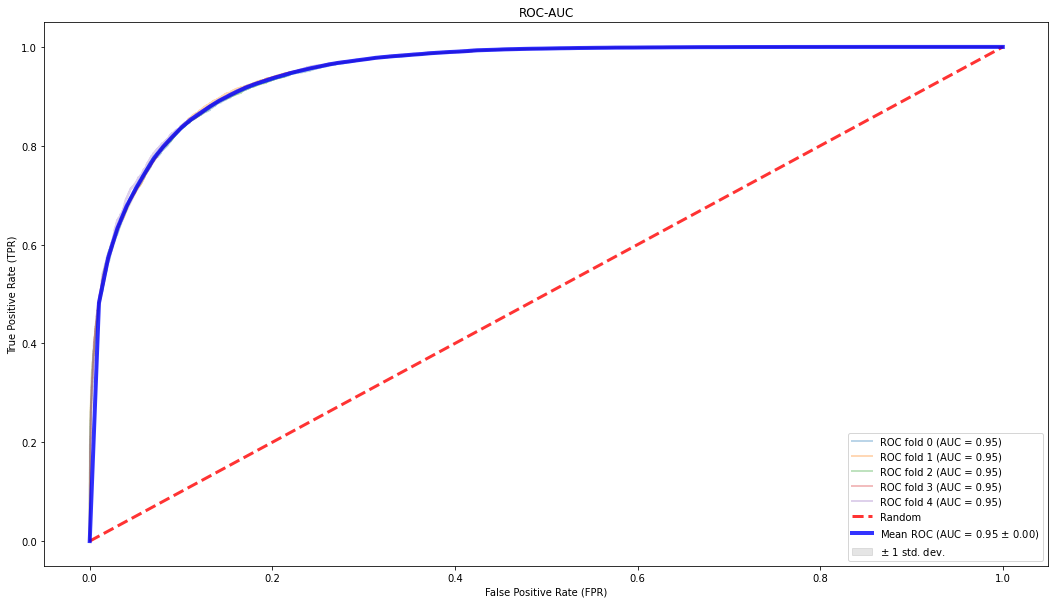

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

for train_clean in data:
  X, y = get_train_data(train_clean)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)

  fprs, tprs, scores = [], [], []

  for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(rf, train)
    fpr, tpr, auc_score = compute_roc_auc(rf, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

  plot_roc_curve(fprs, tprs)
  plt.show()

### Performing LIME

In [ ]:
train_cleaned_features[train_cleaned_features.index == 298805]

In [ ]:
choosen_instance = X_test.iloc[[421]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

In [ ]:
train_cleaned_features[train_cleaned_features.index == 21066]

In [ ]:
choosen_instance = X_test.iloc[[281]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)